In [3]:
from superfv import EulerSolver, initial_conditions
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

In [4]:
H0 = 1
rho0 = 1
P0 = 1
gamma = 1.4
T = 1


def analytical_solution(array_slicer, x, y, z, t):
    _slc = array_slicer
    out = np.empty((len(_slc.idxs), *x.shape))

    v = (H0 / (1 + H0 * t)) * (x - 0.5)
    rho = rho0 / (1 + H0 * t)
    P = P0 / ((1 + H0 * t) ** gamma)

    out[_slc("rho")] = rho
    out[_slc("mx")] = rho * v
    out[_slc("my")] = 0
    out[_slc("mz")] = 0
    out[_slc("E")] = 0.5 * rho * v**2 + (1 / (gamma - 1)) * P

    return out


solver = EulerSolver(
    ic=partial(initial_conditions.velocity_ramp, H0=H0, rho0=rho0, P0=P0),
    bcx=("dirichlet", "dirichlet"),
    x_dirichlet=(analytical_solution, analytical_solution),
    gamma=gamma,
    lazy_primitives=False,
    nx=64,
    p=3,
    CFL=0.4,
)
solver.run(1.0)

100%|██████████| 1.0/1.0 [00:01]                 


In [5]:
err = np.sqrt(
    np.mean(
        np.square(
            solver.snapshots[-1]["u"]
            - analytical_solution(solver.array_slicer, solver.X, solver.Y, solver.Z, T),
        )
    )
)

print("L2 error norm:", err)

L2 error norm: 5.311372900042556e-07


Text(0, 0.5, '$E$')

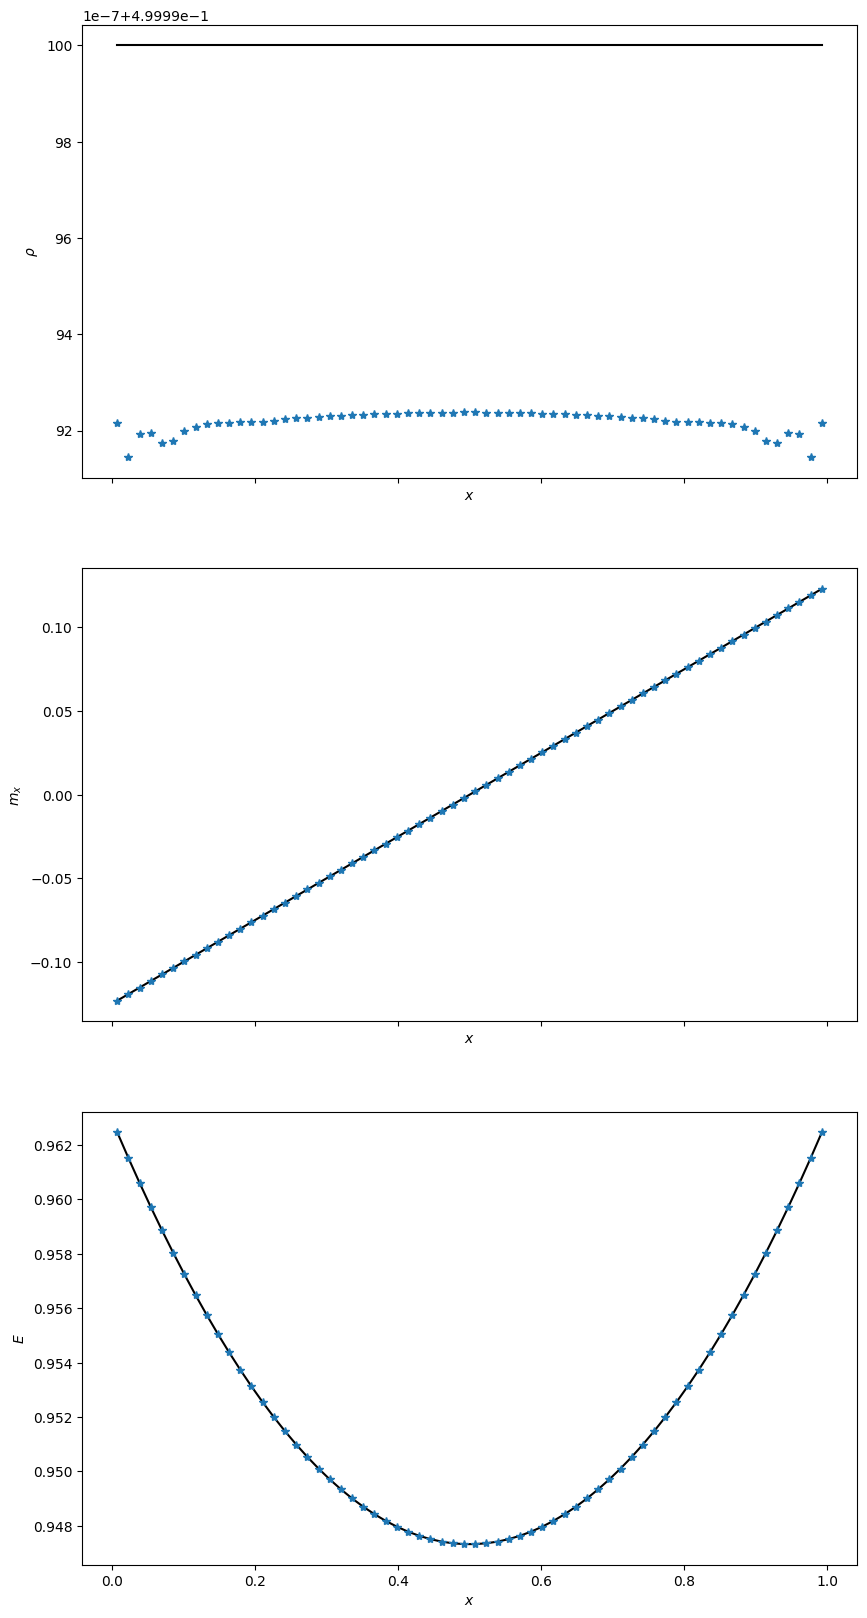

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(10, 20), sharex=True)
axs[0].plot(
    solver.X.flatten(),
    analytical_solution(solver.array_slicer, solver.X, solver.Y, solver.Z, T)[
        0
    ].flatten(),
    color="k",
)
solver.plot_1d_slice(
    axs[0], "rho", array="u", x=None, t=T, marker="*", linestyle="none"
)
axs[0].set_ylabel(r"$\rho$")
axs[1].plot(
    solver.X.flatten(),
    analytical_solution(solver.array_slicer, solver.X, solver.Y, solver.Z, T)[
        1
    ].flatten(),
    color="k",
)
solver.plot_1d_slice(axs[1], "mx", array="u", x=None, t=T, marker="*", linestyle="none")
axs[1].set_ylabel(r"$m_x$")
axs[2].plot(
    solver.X.flatten(),
    analytical_solution(solver.array_slicer, solver.X, solver.Y, solver.Z, T)[
        4
    ].flatten(),
    color="k",
)
solver.plot_1d_slice(axs[2], "E", array="u", x=None, t=T, marker="*", linestyle="none")
axs[2].set_ylabel(r"$E$")